In [90]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data Understanding and Preparation
### Let's take a look at our dataset. Here we read the data of SF business inspection CSV file 


In [91]:
sf_df = pd.read_csv('SF_Inspections.csv')
sf_df.head(5)

business_id     business_name business_address  business_city  \
0  10           Tiramisu Kitchen  033 Belden Pl    San Francisco   
1  10           Tiramisu Kitchen  033 Belden Pl    San Francisco   
2  10           Tiramisu Kitchen  033 Belden Pl    San Francisco   
3  10           Tiramisu Kitchen  033 Belden Pl    San Francisco   
4  10           Tiramisu Kitchen  033 Belden Pl    San Francisco   

  business_state business_postal_code  business_latitude  business_longitude  \
0  CA             94104                37.791116         -122.403816           
1  CA             94104                37.791116         -122.403816           
2  CA             94104                37.791116         -122.403816           
3  CA             94104                37.791116         -122.403816           
4  CA             94104                37.791116         -122.403816           

          business_location  business_phone_number inspection_id  \
0  (37.791116, -122.403816) NaN                     10_20140114    
1  (37.791116, -122.403816) NaN                     10_20140114    
2  (37.791116, -122.403816) NaN                     10_20140114    
3  (37.791116, -122.403816) NaN                     10_20140729    
4  (37.791116, -122.403816) NaN                     10_20140729    

          inspection_date  inspection_score        inspection_type  \
0  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
1  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
2  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
3  07/29/2014 12:00:00 AM  94.0              Routine - Unscheduled   
4  07/29/2014 12:00:00 AM  94.0              Routine - Unscheduled   

         violation_id                               violation_description  \
0  10_20140114_103119  Inadequate and inaccessible handwashing facilities   
1  10_20140114_103145  Improper storage of equipment utensils or linens     
2  10_20140114_103154  Unclean or degraded floors walls or ceilings         
3  10_20140729_103144  Unapproved or unmaintained equipment or utensils     
4  10_20140729_103129  Insufficient hot water or running water              

   risk_category  
0  Moderate Risk  
1  Low Risk       
2  Low Risk       
3  Low Risk       
4  Moderate Risk

In [92]:
sf_df.shape

(53555, 17)

So each row consists of 17 features:
> 1. **business_id**: Unique number used for identification of the business 
> 2. **business_name**: Business Name
> 3. **business_address**: The address of the business 
> 4. **business_city**: The City (here all records have the same city San-Francisco)
> 5. **business_state**: The state (here all records have the same state CA)
> 6. **business_postal_code**: The latitude value of the business location
> 7. **business_latitude**: The latitude value of the business location
> 8. **business_longitude**: The longitude value of the business location
> 9. **business_location**: A tuple of the latitude and the longitude values
> 10. **business_phone_number**: Business phone number
> 11. **inspection_id**: Unique number that identifying the inspection case
> 12. **inspection_date**: The date of the inspection process
> 13. **inspection_score**: A score out of 100 that the business got after the inspection
> 14. **inspection_type**: Routine-Unscheduled, complaint, New ownership, new construction or Non-inspection site visit.  In our dataset this feature has only one value “Routine-Unscheduled”
> 15. **violation_id**: Identification of violation 
> 16. **violation_description**: Short description of the violation if any
> 17. **risk_category**: Classification of the business category, Low, Moderate or High Risk

In [93]:
copy_sf_df = sf_df
copy_sf_df.head(7)

business_id              business_name business_address  business_city  \
0  10           Tiramisu Kitchen           033 Belden Pl    San Francisco   
1  10           Tiramisu Kitchen           033 Belden Pl    San Francisco   
2  10           Tiramisu Kitchen           033 Belden Pl    San Francisco   
3  10           Tiramisu Kitchen           033 Belden Pl    San Francisco   
4  10           Tiramisu Kitchen           033 Belden Pl    San Francisco   
5  4864         DRAGON CITY BAKERY & CAFE  2367 MISSION St  San Francisco   
6  79782        Deli 23                    2449 23rd St     San Francisco   

  business_state business_postal_code  business_latitude  business_longitude  \
0  CA             94104                37.791116         -122.403816           
1  CA             94104                37.791116         -122.403816           
2  CA             94104                37.791116         -122.403816           
3  CA             94104                37.791116         -122.403816           
4  CA             94104                37.791116         -122.403816           
5  CA             94110                37.759174         -122.419066           
6  CA             94110               NaN                NaN                   

          business_location  business_phone_number   inspection_id  \
0  (37.791116, -122.403816) NaN                     10_20140114      
1  (37.791116, -122.403816) NaN                     10_20140114      
2  (37.791116, -122.403816) NaN                     10_20140114      
3  (37.791116, -122.403816) NaN                     10_20140729      
4  (37.791116, -122.403816) NaN                     10_20140729      
5  (37.759174, -122.419066)  1.415583e+10           4864_20161206    
6  NaN                      NaN                     79782_20160503   

          inspection_date  inspection_score        inspection_type  \
0  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
1  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
2  01/14/2014 12:00:00 AM  92.0              Routine - Unscheduled   
3  07/29/2014 12:00:00 AM  94.0              Routine - Unscheduled   
4  07/29/2014 12:00:00 AM  94.0              Routine - Unscheduled   
5  12/06/2016 12:00:00 AM  84.0              Routine - Unscheduled   
6  05/03/2016 12:00:00 AM  92.0              Routine - Unscheduled   

            violation_id  \
0  10_20140114_103119      
1  10_20140114_103145      
2  10_20140114_103154      
3  10_20140729_103144      
4  10_20140729_103129      
5  4864_20161206_103157    
6  79782_20160503_103120   

                                        violation_description  risk_category  
0  Inadequate and inaccessible handwashing facilities          Moderate Risk  
1  Improper storage of equipment utensils or linens            Low Risk       
2  Unclean or degraded floors walls or ceilings                Low Risk       
3  Unapproved or unmaintained equipment or utensils            Low Risk       
4  Insufficient hot water or running water                     Moderate Risk  
5  Food safety certificate or food handler card not available  Low Risk       
6  Moderate risk food holding temperature                      Moderate Risk

In [94]:
copy_sf_df.dropna(subset=['business_id','business_name',
                          'business_address','business_city','business_state',
                          'business_postal_code','business_latitude','business_longitude',
                          'business_location','business_phone_number','inspection_id',
                          'inspection_id','inspection_date','inspection_score','inspection_type',
                          'violation_id','violation_description'],inplace=True)

#### Group business by risk_category 

We will use summarize the inspection data by `risk_category`. The general process involves the following steps:
1. **Split:** Splitting the data into groups based on the risk_category.
2. **Apply:** Applying the count and mean function to each group independently:
3. **Combine:** Combining the results into a data structure.

In [95]:
df_risk = copy_sf_df.groupby('risk_category', axis=0).count()
df_risk.head(10)

business_id  business_name  business_address  business_city  \
risk_category                                                                
High Risk      786          786            786               786             
Low Risk       3468         3468           3468              3468            
Moderate Risk  2245         2245           2245              2245            

               business_state  business_postal_code  business_latitude  \
risk_category                                                            
High Risk      786             786                   786                 
Low Risk       3468            3468                  3468                
Moderate Risk  2245            2245                  2245                

               business_longitude  business_location  business_phone_number  \
risk_category                                                                 
High Risk      786                 786                786                     
Low Risk       3468                3468               3468                    
Moderate Risk  2245                2245               2245                    

               inspection_id  inspection_date  inspection_score  \
risk_category                                                     
High Risk      786            786              786                
Low Risk       3468           3468             3468               
Moderate Risk  2245           2245             2245               

               inspection_type  violation_id  violation_description  
risk_category                                                        
High Risk      786              786           786                    
Low Risk       3468             3468          3468                   
Moderate Risk  2245             2245          2245

In [96]:
df_risk_score = copy_sf_df.groupby('risk_category', axis=0)['inspection_score'].mean()
df_risk_score.head(10)

risk_category
High Risk        80.583969
Low Risk         88.096886
Moderate Risk    86.115367
Name: inspection_score, dtype: float64

In [97]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  2.2.2


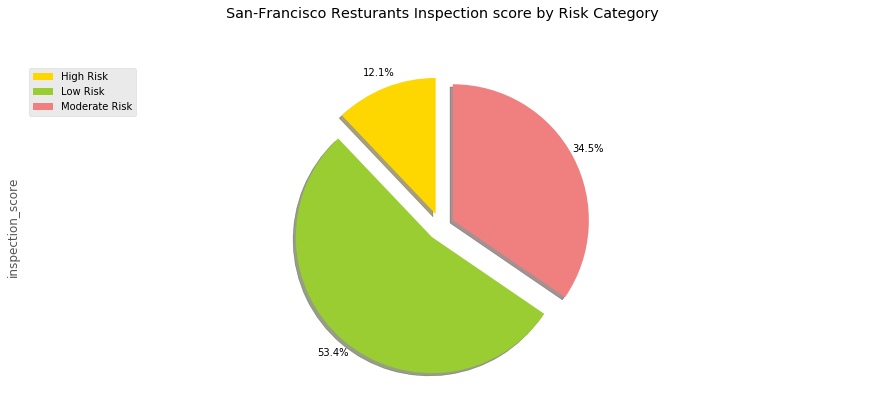

In [98]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df_risk['inspection_score'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('San-Francisco Resturants Inspection score by Risk Category', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_risk.index, loc='upper left') 

plt.show()

In [99]:
def getMonth(s):
    return s.split("/")[0]

def getDay(s):
    return s.split("/")[1]

def getYear(s):
     ss= s.split("/")[2]
     return ss[:4]

def getYearMonth(s):
    return s.split("/")[1]+"/"+s.split("/")[2]


In [100]:
copy_sf_df['year']= copy_sf_df['inspection_date'].apply(lambda x: getYear(str(x)))
copy_sf_df['Month']= copy_sf_df['inspection_date'].apply(lambda x: getMonth(str(x)))
copy_sf_df['day']= copy_sf_df['inspection_date'].apply(lambda x: getDay(str(x)))
copy_sf_df.head(10)

business_id                                      business_name  \
5   4864         DRAGON CITY BAKERY & CAFE                           
25  5813         LICK MIDDLE SCHOOL                                  
26  64380        Michael Mina Restaurant                             
43  4787         TONY BALONEY'S                                      
49  33700        Casa Guadalupe #3                                   
50  5631         AT&T -Room 5331 GILROY GARLIC FRIES/view [145161]   
51  5633         AT&T - FIELD CLUB CONCESSION [145185]               
52  5624         AT&T - DERBY GRILL Room 5311 [145154]               
59  33700        Casa Guadalupe #3                                   
60  59838        OTD                                                 

                business_address  business_city business_state  \
5   2367 MISSION St               San Francisco  CA              
25  1220 Noe St                   San Francisco  CA              
26  252 California St             San Francisco  CA              
43  1098 HOWARD St                San Francisco  CA              
49  2999 MISSION                  San Francisco  CA              
50  24 WILLIE MAYS PLAZA 5.24.02  San Francisco  CA              
51  24 WILLIE MAYS PLAZA 1.09.04  San Francisco  CA              
52  24 WILLIE MAYS PLAZA 5.07.02  San Francisco  CA              
59  2999 MISSION                  San Francisco  CA              
60  2232 Bush St                  San Francisco  CA              

   business_postal_code  business_latitude  business_longitude  \
5   94110                37.759174         -122.419066           
25  94114                37.749490         -122.431750           
26  94111                37.793338         -122.399583           
43  94103                37.778033         -122.409430           
49  94110                37.749194         -122.418116           
50  94107                37.778382         -122.391151           
51  94107                37.778382         -122.391151           
52  94107                37.778382         -122.391151           
59  94110                37.749194         -122.418116           
60  94115                37.786988         -122.434074           

           business_location  business_phone_number   inspection_id  \
5   (37.759174, -122.419066)  1.415583e+10           4864_20161206    
25  (37.74949, -122.43175)    1.415582e+10           5813_20140226    
26  (37.793338, -122.399583)  1.415535e+10           64380_20160414   
43  (37.778033, -122.40943)   1.415586e+10           4787_20160628    
49  (37.749194, -122.418116)  1.415588e+10           33700_20160412   
50  (37.778382, -122.391151)  1.415597e+10           5631_20160814    
51  (37.778382, -122.391151)  1.415597e+10           5633_20160814    
52  (37.778382, -122.391151)  1.415597e+10           5624_20160814    
59  (37.749194, -122.418116)  1.415588e+10           33700_20141117   
60  (37.786988, -122.434074)  1.415593e+10           59838_20160531   

           inspection_date  inspection_score        inspection_type  \
5   12/06/2016 12:00:00 AM  84.0              Routine - Unscheduled   
25  02/26/2014 12:00:00 AM  93.0              Routine - Unscheduled   
26  04/14/2016 12:00:00 AM  86.0              Routine - Unscheduled   
43  06/28/2016 12:00:00 AM  83.0              Routine - Unscheduled   
49  04/12/2016 12:00:00 AM  90.0              Routine - Unscheduled   
50  08/14/2016 12:00:00 AM  94.0              Routine - Unscheduled   
51  08/14/2016 12:00:00 AM  94.0              Routine - Unscheduled   
52  08/14/2016 12:00:00 AM  96.0              Routine - Unscheduled   
59  11/17/2014 12:00:00 AM  90.0              Routine - Unscheduled   
60  05/31/2016 12:00:00 AM  92.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   
50  5631_20160814_103118    
51  5633_201

In [101]:
sf_df_year = copy_sf_df.groupby(['risk_category','year'])['inspection_score'].count()
sf_df_year.head(20)


risk_category  year
High Risk      2014    266 
               2015    248 
               2016    272 
Low Risk       2014    1360
               2015    838 
               2016    1270
Moderate Risk  2014    772 
               2015    585 
               2016    888 
Name: inspection_score, dtype: int64

In [102]:
un_SF_df = sf_df_year.unstack()

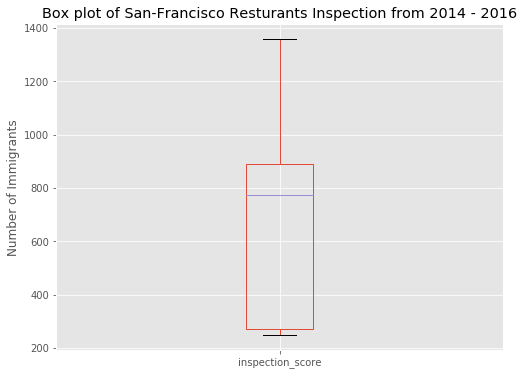

In [103]:
sf_df_year.plot(kind='box', figsize=(8, 6))

plt.title('Box plot of San-Francisco Resturants Inspection from 2014 - 2016')
plt.ylabel('Number of Immigrants')

plt.show()

In [104]:
years = list(map(str, range(2014, 2016)))

sf_df_year.index

MultiIndex(levels=[['High Risk', 'Low Risk', 'Moderate Risk'], ['2014', '2015', '2016']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['risk_category', 'year'])

In [105]:
df_gptest = copy_sf_df[['risk_category','year','inspection_score']]
df_risk_year = df_gptest.groupby(['risk_category','year'],as_index= False).count()
df_risk_year

risk_category  year  inspection_score
0  High Risk      2014  266             
1  High Risk      2015  248             
2  High Risk      2016  272             
3  Low Risk       2014  1360            
4  Low Risk       2015  838             
5  Low Risk       2016  1270            
6  Moderate Risk  2014  772             
7  Moderate Risk  2015  585             
8  Moderate Risk  2016  888

In [106]:
all(isinstance(column, str) for column in df_risk_year.columns)

True

### We groupd the inspections by year for each category low,moderate and high

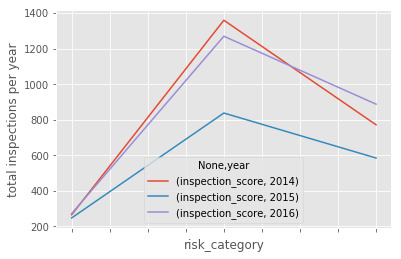

In [107]:
grouped_pivot = df_risk_year.pivot(index='risk_category',columns='year').plot()
#grouped_pivot
plt.ylabel('total inspections per year');

In [108]:
import seaborn as sns
import re

In [109]:
new_SF_df = copy_sf_df
new_SF_df['business_address'] = new_SF_df['business_address'].str.replace('\d+', '')
new_SF_df.head()

business_id              business_name business_address  business_city  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION St      San Francisco   
25  5813         LICK MIDDLE SCHOOL          Noe St          San Francisco   
26  64380        Michael Mina Restaurant     California St   San Francisco   
43  4787         TONY BALONEY'S              HOWARD St       San Francisco   
49  33700        Casa Guadalupe #3           MISSION         San Francisco   

   business_state business_postal_code  business_latitude  business_longitude  \
5   CA             94110                37.759174         -122.419066           
25  CA             94114                37.749490         -122.431750           
26  CA             94111                37.793338         -122.399583           
43  CA             94103                37.778033         -122.409430           
49  CA             94110                37.749194         -122.418116           

           business_location  business_phone_number   inspection_id  \
5   (37.759174, -122.419066)  1.415583e+10           4864_20161206    
25  (37.74949, -122.43175)    1.415582e+10           5813_20140226    
26  (37.793338, -122.399583)  1.415535e+10           64380_20160414   
43  (37.778033, -122.40943)   1.415586e+10           4787_20160628    
49  (37.749194, -122.418116)  1.415588e+10           33700_20160412   

           inspection_date  inspection_score        inspection_type  \
5   12/06/2016 12:00:00 AM  84.0              Routine - Unscheduled   
25  02/26/2014 12:00:00 AM  93.0              Routine - Unscheduled   
26  04/14/2016 12:00:00 AM  86.0              Routine - Unscheduled   
43  06/28/2016 12:00:00 AM  83.0              Routine - Unscheduled   
49  04/12/2016 12:00:00 AM  90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  Low Risk        
25  Sewage or wastewater contamination                          High Risk       
26  Unclean or degraded floors walls or ceilings                Low Risk        
43  Moderate risk vermin infestation                            Moderate Risk   
49  Inadequate and inaccessible handwashing facilities          Moderate Risk   

    year Month day  
5   2016  12    06  
25  2014  02    26  
26  2016  04    14  
43  2016  06    28  
49  2016  04    12

In [110]:
new_SF_df['business_address'] = new_SF_df['business_address'].str.replace('\sSt', '')
new_SF_df.head()

business_id              business_name business_address  business_city  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION         San Francisco   
25  5813         LICK MIDDLE SCHOOL          Noe             San Francisco   
26  64380        Michael Mina Restaurant     California      San Francisco   
43  4787         TONY BALONEY'S              HOWARD          San Francisco   
49  33700        Casa Guadalupe #3           MISSION         San Francisco   

   business_state business_postal_code  business_latitude  business_longitude  \
5   CA             94110                37.759174         -122.419066           
25  CA             94114                37.749490         -122.431750           
26  CA             94111                37.793338         -122.399583           
43  CA             94103                37.778033         -122.409430           
49  CA             94110                37.749194         -122.418116           

           business_location  business_phone_number   inspection_id  \
5   (37.759174, -122.419066)  1.415583e+10           4864_20161206    
25  (37.74949, -122.43175)    1.415582e+10           5813_20140226    
26  (37.793338, -122.399583)  1.415535e+10           64380_20160414   
43  (37.778033, -122.40943)   1.415586e+10           4787_20160628    
49  (37.749194, -122.418116)  1.415588e+10           33700_20160412   

           inspection_date  inspection_score        inspection_type  \
5   12/06/2016 12:00:00 AM  84.0              Routine - Unscheduled   
25  02/26/2014 12:00:00 AM  93.0              Routine - Unscheduled   
26  04/14/2016 12:00:00 AM  86.0              Routine - Unscheduled   
43  06/28/2016 12:00:00 AM  83.0              Routine - Unscheduled   
49  04/12/2016 12:00:00 AM  90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  Low Risk        
25  Sewage or wastewater contamination                          High Risk       
26  Unclean or degraded floors walls or ceilings                Low Risk        
43  Moderate risk vermin infestation                            Moderate Risk   
49  Inadequate and inaccessible handwashing facilities          Moderate Risk   

    year Month day  
5   2016  12    06  
25  2014  02    26  
26  2016  04    14  
43  2016  06    28  
49  2016  04    12

#### Using busnisses with address, let's duplicate each business's address based on how much they have been inspected to the total inspections.

In [111]:
new_SF_df['business_address'] = new_SF_df['business_address'].str.replace('\sSt', '')
new_SF_df.head()

business_id              business_name business_address  business_city  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION         San Francisco   
25  5813         LICK MIDDLE SCHOOL          Noe             San Francisco   
26  64380        Michael Mina Restaurant     California      San Francisco   
43  4787         TONY BALONEY'S              HOWARD          San Francisco   
49  33700        Casa Guadalupe #3           MISSION         San Francisco   

   business_state business_postal_code  business_latitude  business_longitude  \
5   CA             94110                37.759174         -122.419066           
25  CA             94114                37.749490         -122.431750           
26  CA             94111                37.793338         -122.399583           
43  CA             94103                37.778033         -122.409430           
49  CA             94110                37.749194         -122.418116           

           business_location  business_phone_number   inspection_id  \
5   (37.759174, -122.419066)  1.415583e+10           4864_20161206    
25  (37.74949, -122.43175)    1.415582e+10           5813_20140226    
26  (37.793338, -122.399583)  1.415535e+10           64380_20160414   
43  (37.778033, -122.40943)   1.415586e+10           4787_20160628    
49  (37.749194, -122.418116)  1.415588e+10           33700_20160412   

           inspection_date  inspection_score        inspection_type  \
5   12/06/2016 12:00:00 AM  84.0              Routine - Unscheduled   
25  02/26/2014 12:00:00 AM  93.0              Routine - Unscheduled   
26  04/14/2016 12:00:00 AM  86.0              Routine - Unscheduled   
43  06/28/2016 12:00:00 AM  83.0              Routine - Unscheduled   
49  04/12/2016 12:00:00 AM  90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  Low Risk        
25  Sewage or wastewater contamination                          High Risk       
26  Unclean or degraded floors walls or ceilings                Low Risk        
43  Moderate risk vermin infestation                            Moderate Risk   
49  Inadequate and inaccessible handwashing facilities          Moderate Risk   

    year Month day  
5   2016  12    06  
25  2014  02    26  
26  2016  04    14  
43  2016  06    28  
49  2016  04    12

In [112]:
new_SF_df.Month = new_SF_df.Month.astype(np.int64)
new_SF_df.day = new_SF_df.day.astype(np.int64)

In [113]:
ins_count = new_SF_df.groupby('business_postal_code').count()
ins_count

business_id  business_name  business_address  \
business_postal_code                                                 
92672                 4            4              4                  
941                   2            2              2                  
94102                 251          251            251                
94103                 815          815            815                
94104                 60           60             60                 
94105                 22           22             22                 
94107                 414          414            414                
94108                 93           93             93                 
94109                 311          311            311                
94110                 1094         1094           1094               
941102019             3            3              3                  
94111                 66           66             66                 
94112                 452          452            452                
94114                 412          412            412                
94115                 330          330            330                
94116                 36           36             36                 
94117                 326          326            326                
94118                 124          124            124                
94121                 132          132            132                
94122                 195          195            195                
94123                 387          387            387                
94124                 84           84             84                 
94127                 191          191            191                
94131                 183          183            183                
94132                 255          255            255                
94133                 140          140            140                
94134                 111          111            111                
94158                 4            4              4                  
CA                    2            2              2                  

                      business_city  business_state  business_latitude  \
business_postal_code                                                     
92672                 4              4               4                   
941                   2              2               2                   
94102                 251            251             251                 
94103                 815            815             815                 
94104                 60             60              60                  
94105                 22             22              22                  
94107                 414            414             414                 
94108                 93             93              93                  
94109                 311            311             311                 
94110                 1094           1094            1094                
941102019             3              3               3                   
94111                 66             66              66                  
94112                 452            452             452                 
94114                 412            412             412                 
94115                 330            330             330                 
94116                 36             36              36                  
94117                 326            326             326                 
94118                 124            124             124                 
94121                 132            132             132                 
94122                 195            195             195                 
94123                 387            387             387                 
94124                 84             84              84                  
94127                 191            191             191                 
9

In [114]:
df_all_year = un_SF_df.T
df_all_year

risk_category  High Risk  Low Risk  Moderate Risk
year                                             
2014           266        1360      772          
2015           248        838       585          
2016           272        1270      888

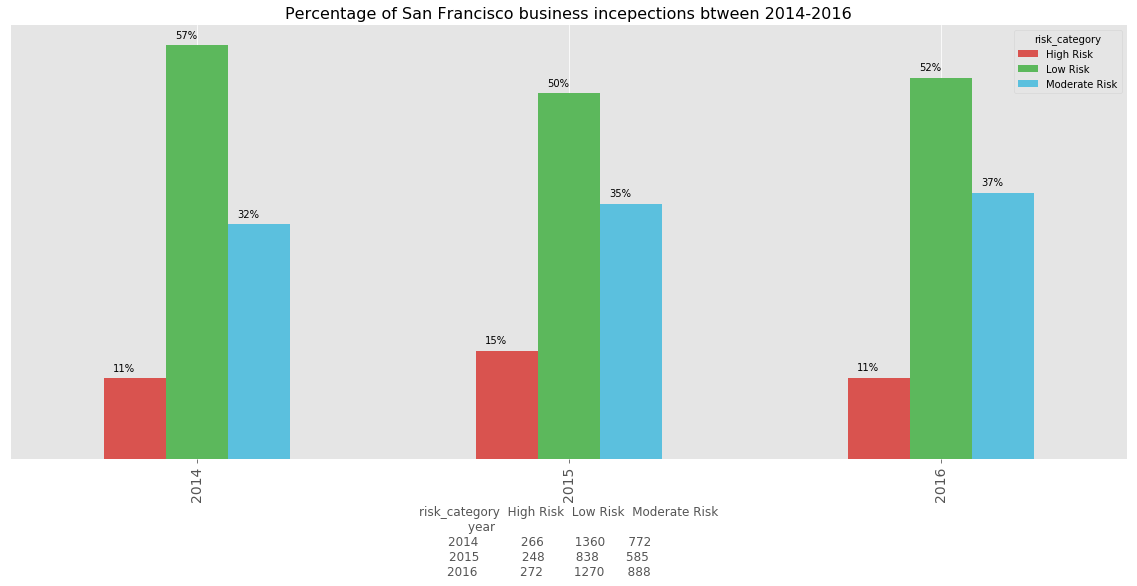

In [115]:
ax = df_all_year.div(df_all_year.sum(1), axis=0).plot(kind='bar', color=['#d9534f','#5cb85c', '#5bc0de' ], figsize=(20, 8))

ax.set_title("Percentage of San Francisco business incepections btween 2014-2016",fontsize=16)
plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
ax.set_xlabel(df_all_year)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.15*width, p.get_y() + height + 0.01))

In [116]:
sf_count= new_SF_df['business_postal_code'].value_counts().to_frame()
sf_count .rename(columns={'business_postal_code': 'Count'}, inplace=True)
sf_count.index.name ='business_postal_code'
sf_count.reset_index(level=0, inplace=True)
sf_count

business_postal_code  Count
0   94110                1094 
1   94103                815  
2   94112                452  
3   94107                414  
4   94114                412  
5   94123                387  
6   94115                330  
7   94117                326  
8   94109                311  
9   94132                255  
10  94102                251  
11  94122                195  
12  94127                191  
13  94131                183  
14  94133                140  
15  94121                132  
16  94118                124  
17  94134                111  
18  94108                93   
19  94124                84   
20  94111                66   
21  94104                60   
22  94116                36   
23  94105                22   
24  92672                4    
25  94158                4    
26  941102019            3    
27  941                  2    
28  CA                   2

In [119]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


In [120]:
stopwords = set(STOPWORDS)

In [121]:
lst_v_dsc = new_SF_df['violation_description'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)

Using violation description,let's count each violation's description based on how much they contribute to the total inspections. 

We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.

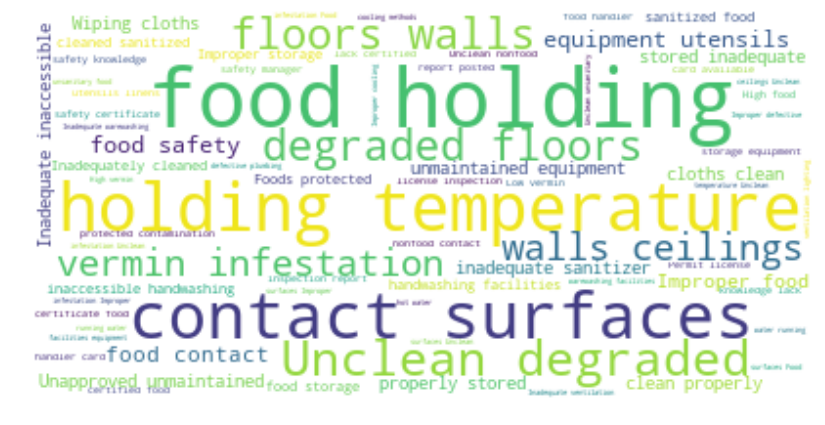

In [122]:
stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [123]:
threshold_scale = np.linspace(sf_count['Count'].min(),
                              sf_count['Count'].max(),
                              6, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
sf_geo = r'san-francisco.json' # geojson file
sf_map.choropleth(
    geo_data = sf_geo,
    data = sf_count,
    columns =['business_postal_code', 'Count'],
    key_on ='feature.properties.DISTRICT',
    threshold_scale=[ 100, 200, 300, 500, 1000],
    fill_color ='BuPu', 
    fill_opacity =0.9, 
    line_opacity =0.9,
    legend_name ='Food inspection in San-Francisco',
    reset = True
)

# display map
sf_map

#### Let's find out how many entries there are in our new dataframe.

In [124]:
new_SF_df.shape

(6499, 20)

So the dataframe consists of 6499 inspections, which took place in period 2014-2016. In order to reduce computational cost, let's just work with the first 100 inspections in this dataset.

In [126]:
# get the first 100 crimes in the df_incidents dataframe
limit = 100
new_SF_df_limt = new_SF_df.iloc[0:limit, :]
new_SF_df_limt.shape

(100, 20)

Now that we reduced the data a little bit, let's visualize where these inspections took place in the city of San Francisco. We will use the default style and we will initialize the zoom level to 12. 

Now let's superimpose the locations of the crimes onto the map. The way to do that in **Folium** is to create a *feature group* with its own features and style and then add it to the sanfran_map.

We can also add some pop-up text that would get displayed when we hover over a marker. Let's make each marker display the category of the inspection when hovered over.

In [128]:
# instantiate a feature group for the incidents in the dataframe
inspection = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(new_SF_df_limt.business_latitude, new_SF_df_limt.business_longitude):
    inspection.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(new_SF_df_limt.business_latitude)
longitudes = list(new_SF_df_limt.business_longitude)
labels = list(new_SF_df_limt.risk_category)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(sf_map)    
    
# add incidents to map
sf_map.add_child(inspection)

In [129]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
sanfran_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
inspection = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(new_SF_df.business_latitude, new_SF_df.business_longitude, new_SF_df.risk_category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(inspection)

# display map
sanfran_map

## Modeling
In this part of our project we will apply a machine learning technique to cluster and classifying the inspection in order to have a better understanding of inspection process. 
### Features extraction
Before start the modeling stage We need to:
> convert inspection_date field to date time object

> drop unnecessary fields from the dataset 

In [130]:
new_SF_df['inspection_date'] = pd.to_datetime(new_SF_df['inspection_date'])


In [132]:
m_SF_df = new_SF_df.drop(columns=['business_location', 'business_phone_number', 'business_city' ,'business_state'])
m_SF_df.head(5)

business_id              business_name business_address  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION          
25  5813         LICK MIDDLE SCHOOL          Noe              
26  64380        Michael Mina Restaurant     California       
43  4787         TONY BALONEY'S              HOWARD           
49  33700        Casa Guadalupe #3           MISSION          

   business_postal_code  business_latitude  business_longitude  \
5   94110                37.759174         -122.419066           
25  94114                37.749490         -122.431750           
26  94111                37.793338         -122.399583           
43  94103                37.778033         -122.409430           
49  94110                37.749194         -122.418116           

     inspection_id inspection_date  inspection_score        inspection_type  \
5   4864_20161206  2016-12-06       84.0              Routine - Unscheduled   
25  5813_20140226  2014-02-26       93.0              Routine - Unscheduled   
26  64380_20160414 2016-04-14       86.0              Routine - Unscheduled   
43  4787_20160628  2016-06-28       83.0              Routine - Unscheduled   
49  33700_20160412 2016-04-12       90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  Low Risk        
25  Sewage or wastewater contamination                          High Risk       
26  Unclean or degraded floors walls or ceilings                Low Risk        
43  Moderate risk vermin infestation                            Moderate Risk   
49  Inadequate and inaccessible handwashing facilities          Moderate Risk   

    year  Month  day  
5   2016  12     6    
25  2014  2      26   
26  2016  4      14   
43  2016  6      28   
49  2016  4      12

Let’s see how many of each class is in our data set 

In [133]:
m_SF_df['risk_category'].value_counts()


Low Risk         3468
Moderate Risk    2245
High Risk        786 
Name: risk_category, dtype: int64

3468 business have been labeled as Low Risk and 2245 are Moderate Risk while 786 have been considered High Risk

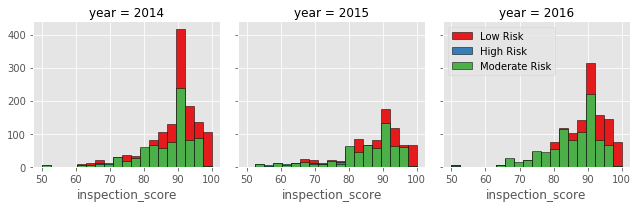

In [134]:
bins = np.linspace(m_SF_df.inspection_score.min(), m_SF_df.inspection_score.max(), 20)
g = sns.FacetGrid(m_SF_df, col="year", hue="risk_category", palette="Set1", col_wrap=3)
g.map(plt.hist, 'inspection_score', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Lets look at the day of the week businesses were getting inspected 

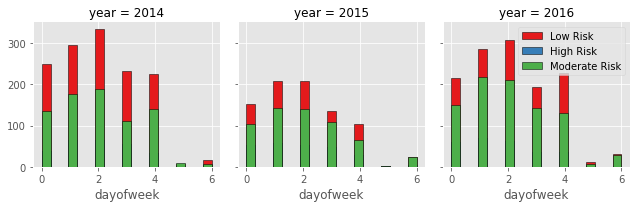

In [136]:
m_SF_df['dayofweek'] = m_SF_df['inspection_date'].dt.dayofweek
bins = np.linspace(m_SF_df.dayofweek.min(), m_SF_df.dayofweek.max(), 20)
g = sns.FacetGrid(m_SF_df, col="year", hue="risk_category", palette="Set1", col_wrap=3)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that businesses that get inspected at the end of the week so lets use Feature binarization to set a threshold values less then day 4 

In [138]:
m_SF_df['weekend'] = m_SF_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
m_SF_df.head()

business_id              business_name business_address  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION          
25  5813         LICK MIDDLE SCHOOL          Noe              
26  64380        Michael Mina Restaurant     California       
43  4787         TONY BALONEY'S              HOWARD           
49  33700        Casa Guadalupe #3           MISSION          

   business_postal_code  business_latitude  business_longitude  \
5   94110                37.759174         -122.419066           
25  94114                37.749490         -122.431750           
26  94111                37.793338         -122.399583           
43  94103                37.778033         -122.409430           
49  94110                37.749194         -122.418116           

     inspection_id inspection_date  inspection_score        inspection_type  \
5   4864_20161206  2016-12-06       84.0              Routine - Unscheduled   
25  5813_20140226  2014-02-26       93.0              Routine - Unscheduled   
26  64380_20160414 2016-04-14       86.0              Routine - Unscheduled   
43  4787_20160628  2016-06-28       83.0              Routine - Unscheduled   
49  33700_20160412 2016-04-12       90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  Low Risk        
25  Sewage or wastewater contamination                          High Risk       
26  Unclean or degraded floors walls or ceilings                Low Risk        
43  Moderate risk vermin infestation                            Moderate Risk   
49  Inadequate and inaccessible handwashing facilities          Moderate Risk   

    year  Month  day  dayofweek  weekend  
5   2016  12     6    1          0        
25  2014  2      26   2          0        
26  2016  4      14   3          0        
43  2016  6      28   1          0        
49  2016  4      12   1          0

### Convert Categorical features to numerical values

In [140]:
m_SF_df.groupby(['year'])['risk_category'].value_counts(normalize=True)

year  risk_category
2014  Low Risk         0.567139
      Moderate Risk    0.321935
      High Risk        0.110926
2015  Low Risk         0.501496
      Moderate Risk    0.350090
      High Risk        0.148414
2016  Low Risk         0.522634
      Moderate Risk    0.365432
      High Risk        0.111934
Name: risk_category, dtype: float64

from the result above we can see that in all years the low risk businesses are more than 50%. On the other hand the High Risk businesses are almost the same in both 2014 and 2016 while increasing in 2015 from 11% to almost 15%. Moreover the Moderate Risk is increasing every year from 32% in 2014 to 35% in 2015 and 36.5% in 2016.

Lets convert the risk categories into 1 for Low Risk, 2 for Moderate Risk and 3 for High Risk:

In [141]:
m_SF_df['risk_category'].replace(to_replace=['Low Risk','Moderate Risk','High Risk'], value=[1,2,3],inplace=True)
m_SF_df.head()

business_id              business_name business_address  \
5   4864         DRAGON CITY BAKERY & CAFE   MISSION          
25  5813         LICK MIDDLE SCHOOL          Noe              
26  64380        Michael Mina Restaurant     California       
43  4787         TONY BALONEY'S              HOWARD           
49  33700        Casa Guadalupe #3           MISSION          

   business_postal_code  business_latitude  business_longitude  \
5   94110                37.759174         -122.419066           
25  94114                37.749490         -122.431750           
26  94111                37.793338         -122.399583           
43  94103                37.778033         -122.409430           
49  94110                37.749194         -122.418116           

     inspection_id inspection_date  inspection_score        inspection_type  \
5   4864_20161206  2016-12-06       84.0              Routine - Unscheduled   
25  5813_20140226  2014-02-26       93.0              Routine - Unscheduled   
26  64380_20160414 2016-04-14       86.0              Routine - Unscheduled   
43  4787_20160628  2016-06-28       83.0              Routine - Unscheduled   
49  33700_20160412 2016-04-12       90.0              Routine - Unscheduled   

             violation_id  \
5   4864_20161206_103157    
25  5813_20140226_103113    
26  64380_20160414_103154   
43  4787_20160628_103131    
49  33700_20160412_103119   

                                         violation_description  risk_category  \
5   Food safety certificate or food handler card not available  1               
25  Sewage or wastewater contamination                          3               
26  Unclean or degraded floors walls or ceilings                1               
43  Moderate risk vermin infestation                            2               
49  Inadequate and inaccessible handwashing facilities          2               

    year  Month  day  dayofweek  weekend  
5   2016  12     6    1          0        
25  2014  2      26   2          0        
26  2016  4      14   3          0        
43  2016  6      28   1          0        
49  2016  4      12   1          0

In [142]:
m_SF_df = m_SF_df.drop(columns=['day','Month','weekend'])

From the dataset we can define our feature set, X as follows:

In [143]:
Feature = m_SF_df[['business_postal_code','business_latitude',
             'business_longitude','inspection_score',
              'year', 'dayofweek']]
my_features = Feature[Feature.business_postal_code.apply(lambda x: x.isnumeric())]
X = my_features
X[0:5]

business_postal_code  business_latitude  business_longitude  \
5   94110                37.759174         -122.419066           
25  94114                37.749490         -122.431750           
26  94111                37.793338         -122.399583           
43  94103                37.778033         -122.409430           
49  94110                37.749194         -122.418116           

    inspection_score  year  dayofweek  
5   84.0              2016  1          
25  93.0              2014  2          
26  86.0              2016  3          
43  83.0              2016  1          
49  90.0              2016  1

To build a machine learning classifier we need a label set Y as follows:

In [144]:
my_class_df = m_SF_df[m_SF_df.business_postal_code.apply(lambda x: x.isnumeric())]
y = my_class_df['risk_category'].values
y[0:5]

array([1, 3, 1, 2, 2])

### Classification 
Now, it is time to use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Logistic Regression

#### K Nearest Neighbor(KNN)
We should find the best k to build the model with the best accuracy.  

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5197, 6) (5197,)
Test set: (1300, 6) (1300,)


In [148]:
Ks = 10

mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc






print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.5215384615384615 with k= 6


In [149]:
neigh = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)
yhatKNN = neigh.predict(X_test)
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatKNN))
print("F1  Accuracy -->", metrics.f1_score(y_test, yhatKNN, average='weighted'))

Train set Accuracy-->  0.6332499518953242
Test set Accuracy --> 0.5215384615384615
F1  Accuracy --> 0.47777033142713926


#### Logistic Regression

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [151]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhatLR = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [152]:
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatLR))

Train set Accuracy-->  0.5358860881277661
Test set Accuracy --> 0.5246153846153846


In [153]:
log_loss(y_test, yhat_prob)

0.9686057941538061

In [155]:
jaccard_similarity_score(y_test, yhatKNN)

0.5215384615384615

In [ ]:
jaccard_similarity_score(y_test, yhatLR)

In [522]:
#f1LR = f1_score(y, yhatLR, average='weighted')
print("Regression F1  Accuracy -->", metrics.f1_score(y_test, yhatLR, average='weighted'))

Regression F1  Accuracy --> 0.36103702553753003


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Using Fourquare to visualize businesses venues
We will make calls to the Foursquare API for different purposes. You will construct a URL to send a request to the API to search for a specific type of venues, to explore a particular business venue, to explore a Foursquare user, to explore a geographical location, and to get trending venues around a location. Also, you will learn how to use the visualization library, Folium, to visualize the results.

### Import necessary Libraries
first we import some libraries that we need to complete our object effeciently 

In [156]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Define Foursquare Credentials
we define Foursquare Credentials and Version. We have already created a Foursquare developer account and have we credentials handy.

In [157]:
CLIENT_ID = 'EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR' # your Foursquare ID
CLIENT_SECRET = '2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY' # your Foursquare Secret
VERSION = '20181022'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR
CLIENT_SECRET:2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY


In order to reduce computational cost, let's just work with the first 100 inspections in this dataset.

In [159]:
# get the first 100 inspections in the our dataframe
df_limit = 100
Top100_SF_df = sf_df.iloc[0:df_limit, :]
Top100_SF_df.shape

(100, 20)

In [160]:
Top100_SF_df.head(20)

business_id                                      business_name  \
5    4864         DRAGON CITY BAKERY & CAFE                           
25   5813         LICK MIDDLE SCHOOL                                  
26   64380        Michael Mina Restaurant                             
43   4787         TONY BALONEY'S                                      
49   33700        Casa Guadalupe #3                                   
50   5631         AT&T -Room 5331 GILROY GARLIC FRIES/view [145161]   
51   5633         AT&T - FIELD CLUB CONCESSION [145185]               
52   5624         AT&T - DERBY GRILL Room 5311 [145154]               
59   33700        Casa Guadalupe #3                                   
60   59838        OTD                                                 
95   32586        Terroir                                             
98   4999         HARVEST MARKET                                      
101  62277        tacos san buena                                     
104  69282        New Jumbo Seafood Restaurant                        
110  5948         BRANDEIS-HILLEL DAY SCHOOL                          
111  180          NENAS RESTAURANT                                    
115  3253         S F GOLF CLUB                                       
125  18826        Fresca Restaurant                                   
130  2134         CHIEFTAIN IRISH PUB, THE                            
141  60544        Manzoni                                             

          business_address  business_city business_state business_postal_code  \
5     MISSION               San Francisco  CA             94110                 
25    Noe                   San Francisco  CA             94114                 
26    California            San Francisco  CA             94111                 
43    HOWARD                San Francisco  CA             94103                 
49    MISSION               San Francisco  CA             94110                 
50    WILLIE MAYS PLAZA ..  San Francisco  CA             94107                 
51    WILLIE MAYS PLAZA ..  San Francisco  CA             94107                 
52    WILLIE MAYS PLAZA ..  San Francisco  CA             94107                 
59    MISSION               San Francisco  CA             94110                 
60    Bush                  San Francisco  CA             94115                 
95    Langton               San Francisco  CA             94103                 
98    MARKET                San Francisco  CA             94114                 
101  th and shotwell        San Francisco  CA             94102                 
104   NORIEGA               San Francisco  CA             94122                 
110   BROTHERHOOD Way       San Francisco  CA             94132                 
111   MISSION               San Francisco  CA             94110                 
115   Junipero Serra Blvd   San Francisco  CA             94132                 
125   FILLMORE              San Francisco  CA             94115                 
130   th                    San Francisco  CA             94103                 
141   Diamond               San Francisco  CA             94131                 

     business_latitude  business_longitude         business_location  \
5    37.759174         -122.419066          (37.759174, -122.419066)   
25   37.749490         -122.431750          (37.74949, -122.43175)     
26   37.793338         -122.399583          (37.793338, -122.399583)   
43   37.778033         -122.409430          (37.778033, -122.40943)    
49   37.749194         -122.418116          (37.749194, -122.418116)   
50   37.778382         -122.391151          (37.778382, -122.391151)   
51   37.778382         -122.391151          (37.778382, -122.391151)   
52   37.778382         -122.391151          (37.778382, -122.391151)   
59   37.749194         -122.418116          (37.749194, -122.418116)   
60   37.786988         -122.434074          (37.786988, -122.434074)   
95   37.776494     

### Define the API URL
Here we will define the corresponding URL and send the GET Request and examine the results
we have chosen one business for the sake of simplicity. This business name is "OMNI S.F. Hotel" it is Low Risk business inspection an it got 96 score. 

In [162]:
latitude = 37.792888
longitude = -122.403135
search_query = 'OMNI S.F. Hotel'
radius = 100
print(search_query + ' .... OK!')

OMNI S.F. Hotel .... OK!


In [163]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR&client_secret=2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY&ll=37.792888,-122.403135&v=20181022&query=OMNI S.F. Hotel&radius=100&limit=30'

In [164]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5be6fc239fb6b71ed1998912'},
 'response': {'venues': [{'id': '4a5ae9a1f964a520e0ba1fe3',
    'name': 'Omni San Francisco Hotel',
    'location': {'address': '500 California St',
     'crossStreet': 'at Montgomery St',
     'lat': 37.793119745957455,
     'lng': -122.4031025916338,
     'labeledLatLngs': [{'label': 'display',
       'lat': 37.793119745957455,
       'lng': -122.4031025916338}],
     'distance': 25,
     'postalCode': '94104',
     'cc': 'US',
     'city': 'San Francisco',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['500 California St (at Montgomery St)',
      'San Francisco, CA 94104',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1fa931735',
      'name': 'Hotel',
      'pluralName': 'Hotels',
      'shortName': 'Hotel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '49

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [165]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head(10)

categories  \
0  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}]   

   hasPerk                        id   location.address location.cc  \
0  False    4a5ae9a1f964a520e0ba1fe3  500 California St  US           

   location.city location.country location.crossStreet  location.distance  \
0  San Francisco  United States    at Montgomery St     25                  

                                                        location.formattedAddress  \
0  [500 California St (at Montgomery St), San Francisco, CA 94104, United States]   

                                                        location.labeledLatLngs  \
0  [{'label': 'display', 'lat': 37.793119745957455, 'lng': -122.4031025916338}]   

   location.lat  location.lng location.postalCode location.state  \
0  37.79312     -122.403103    94104               CA              

                       name    referralId venuePage.id  
0  Omni San Francisco Hotel  v-1541864483  497545373

In [166]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name categories            address  cc           city  \
0  Omni San Francisco Hotel  Hotel      500 California St  US  San Francisco   

         country       crossStreet  distance  \
0  United States  at Montgomery St  25         

                                                                 formattedAddress  \
0  [500 California St (at Montgomery St), San Francisco, CA 94104, United States]   

                                                                 labeledLatLngs  \
0  [{'label': 'display', 'lat': 37.793119745957455, 'lng': -122.4031025916338}]   

        lat         lng postalCode state                        id  
0  37.79312 -122.403103  94104      CA    4a5ae9a1f964a520e0ba1fe3

#### Let's visualize the restaurants that are nearby

In [167]:
dataframe_filtered.name

0    Omni San Francisco Hotel
Name: name, dtype: object

In [168]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Hotel

# add a red circle marker to represent the Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Dragon City Cafe',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Let us check this business rating since it has a Low Risk category.

In [70]:
venue_id = '4a5ae9a1f964a520e0ba1fe3' # ID of Ecco
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.5


 We can see it has a better rating, let's explore it further. let us see how many tips it has.

In [71]:
result['response']['venue']['tips']['count']

46

Let us get the tips and list of associated features

In [72]:
## Ecco Tips
limit = 15 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5be5bae71ed21905134bb134'},
 'response': {'tips': {'count': 46,
   'items': [{'id': '563f8028cd10133b6c53ec8c',
     'createdAt': 1447002152,
     'text': "Great hotel and they offer some exceptional last minute deals, so if you're looking for a place to lay your head before a flight or an impromptu trip, this place is great. Very comfortable rooms",
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/563f8028cd10133b6c53ec8c',
     'photo': {'id': '563f8028cd10133b6c53ec8b',
      'createdAt': 1447002152,
      'source': {'name': 'Swarm for iOS', 'url': 'https://www.swarmapp.com'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/2955249_JI2_JdY1_0Cernm9kZGJWofKLBnebpcTxe3d4E0g8rY.jpg',
      'width': 1440,
      'height': 1920,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/2955249_JI2_JdY1_0Cernm9kZGJWofKLBnebpcTxe3d4E0g8rY.jpg',
     'lang': 'en',
     'li

In [76]:
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'photo', 'photourl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'todo', 'user', 'authorInteractionType'])

In [74]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

text  \
0  Great hotel and they offer some exceptional last minute deals, so if you're looking for a place to lay your head before a flight or an impromptu trip, this place is great. Very comfortable rooms   

   agreeCount  disagreeCount                        id user.firstName  \
0  1           0              563f8028cd10133b6c53ec8c  Nadia           

  user.lastName user.gender  user.id  
0  IssaBella     female      2955249

Because we are using a personal developer account, then we can access only 2 of the hotel's tips, instead of all 15 tips.

We can explore further by asking some question such as:
 > Who is this Nadia that rate this hotel?
 
 > How many tips has this user submitted?
 
 > Does she have complete profile (e.g. image, bio and etc.)?

In [79]:
user_id = '2955249' # user ID with most agree counts and complete profile

url = 'https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data = results['response']['user']

# display features associated with user
user_data.keys()

dict_keys(['id', 'firstName', 'lastName', 'gender', 'canonicalUrl', 'photo', 'friends', 'tips', 'homeCity', 'bio', 'contact', 'photos', 'type', 'mayorships', 'checkins', 'lists', 'lenses'])

In [80]:
print('First Name: ' + user_data['firstName'])
print('Last Name: ' + user_data['lastName'])
print('Home City: ' + user_data['homeCity'])

First Name: Nadia
Last Name: IssaBella
Home City: Vaughan, Canada


We can see she is from Canada and here last name is IssaBella

In [81]:
user_data['tips']

{'count': 598}

Nadia is very active in Foursquare as we can see she has 598 tips. Let us explore them.

In [82]:
# define tips URL
url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

# send GET request and get user's tips
results = requests.get(url).json()
tips = results['response']['tips']['items']

# format column width
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips)

# filter columns
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display user's tips
tips_filtered

text  \
0   I love this place but new armed, this is NOT a good spot for people requiring gluten free menu options.                                                                                                
1   All too often forgotten, but this place is great for a show                                                                                                                                            
2   Great atmosphere. Over priced drinks but it's Toronto's new "hot spot" so it's to be expected.                                                                                                         
3   Dated hotel with limited services. Decent for the price (got it for under $200 on a Saturday night). They need to get valet though; and their parking lot underground is very tight for SUV+vehicles   
4   One of my favourite French bakeries in the city. Sad they're moving but glad they're still in the city. Their Croque Madam is Amazing                                                                  
5   Better than expected brunch! The prime rib Benny was delightful and the Milestone's bundle made it a great deal. $21 for a mimosa, brunch entree and fruit bowl                                        
6   Great place to work!                                                                                                                                                                                   
7   Good pub food. The buffalo dishes (wings and wraps) all let you choose your own sauce and they keep expanding their list of sauces so that's a must here!                                              
8   I've been eating teriyaki here for 20 years and it's still consistently good.                                                                                                                          
9   The chaufa (duck confit fried rice) is amazing and the octopus was the best I ever had.                                                                                                                
10  Obsessed with eating sushi off the floating boats!                                                                                                                                                     
11  The Islamic Noodles are not on the menu but they are the best thing that they serve. Delicious. Just ask and they will make it for you.                                                                
12  Great views, dated rooms, decent overpriced restaurants.                                                                                                                                               
13  Quarter chicken dinners for 30 years now. This location has pretty quick service too, which is nice.                                                                                                   
14  Their burrito bowls are half the size yet the same price as Chipotle. Good but not a great value.                                                                                                      

    agreeCount  disagreeCount                        id  
0   0           0              5acbb72918d43b207f1613ee  
1   0           0              5acbb6fa42d8c203d2ec4b05  
2   0           0              5acbb6e106fb6051a3e807b6  
3   1           0              5acbb6bfa2a6ce50e549fb86  
4   0           0              5acbb671e65d0c69c4bbe1bc  
5   0           0              5acbb63664c8e1313838f0f3  
6   0           0              5a0d10a5270ee74af9616f76  
7   0           0              5a0d1091dd84424429b80416  
8   0           0              58d070b316f0004654564f26  
9   2           0              58d0707f23188e13abf66041  
10  0           0              58d07056a9133064a5f24319  
11  2           0              58d0703cf697e027a3a86700  
12  0           0              58d06f8323188e13abf52c52  
13  1           0              58d06f62a1492670d1018321  
14  0           0              58d06f370b565621421e137d

let us explore one venue with highest agree count

In [83]:
tip_id = '58d0703cf697e027a3a86700' # tip id

# define URL
url = 'http://api.foursquare.com/v2/tips/{}?client_id={}&client_secret={}&v={}'.format(tip_id, CLIENT_ID, CLIENT_SECRET, VERSION)

# send GET Request and examine results
result = requests.get(url).json()
print(result['response']['tip']['venue']['name'])
print(result['response']['tip']['venue']['location'])

Salad King
{'address': '340 Yonge St', 'crossStreet': 'at Gould St', 'lat': 43.65753339935103, 'lng': -79.38158512115479, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65753339935103, 'lng': -79.38158512115479}], 'postalCode': 'M5B 1R7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['340 Yonge St (at Gould St)', 'Toronto ON M5B 1R7', 'Canada']}


From the data above Nadia was in a resturant called "Salad King" in Toronto, Canada

In [84]:
user_friends = json_normalize(user_data['friends']['groups'][0]['items'])
user_friends

bio  \
0                                                                                                   
1                                                                                                   
2  Yoga coach ✌                                                                                     
3  A Canadian Father/Husband, eh! I play hockey, and enjoy many sports and #Beer! #KCCO             
4  Bass player for awesome people.\r\nSales Representative, Sutton Group Summit Realty, Inc.        
5  #Family...#Travel...#Hotels...#Sports - my life...                                               
6  Loves travelling and seeing new places!!!! Amusement parks and tourist attractions are my fav.   
7                                                                                                   
8                                                                                                   
9                                                                                                   

       firstName  gender             homeCity        id       lastName  \
0  Mike           male    Chicago, IL          281962    Hadgis          
1  Matt           male    Madison, NJ          52211496  Gentile         
2  Aslı           female  Canada & Turkey      94833633  Ecem            
3  Allan          male    Alberta, Canada      43156846  F               
4  Nick           male    Mississauga, ON      80685911  Czarnogorski    
5  Life_Is_Short  male    Cambridge, ON        66802456  Life_Is_Short   
6  Jessycka       female  Ajax, Canada         13563006  NaN             
7  Niko           male    Heinola, Suomi       14840005  Salo            
8  Benjamin       male    Toronto, Canada      26599605  NaN             
9  Dan            male    Durban South Africa  16407675  Paruk           

                                     lists.groups  \
0  [{'type': 'created', 'count': 2, 'items': []}]   
1  [{'type': 'created', 'count': 4, 'items': []}]   
2  [{'type': 'created', 'count': 3, 'items': []}]   
3  [{'type': 'created', 'count': 2, 'items': []}]   
4  [{'type': 'created', 'count': 2, 'items': []}]   
5  [{'type': 'created', 'count': 2, 'items': []}]   
6  [{'type': 'created', 'count': 6, 'items': []}]   
7  [{'type': 'created', 'count': 2, 'items': []}]   
8  [{'type': 'created', 'count': 2, 'items': []}]   
9  [{'type': 'created', 'count': 2, 'items': []}]   

                        photo.prefix  \
0  https://fastly.4sqi.net/img/user/   
1  https://fastly.4sqi.net/img/user/   
2  https://fastly.4sqi.net/img/user/   
3  https://fastly.4sqi.net/img/user/   
4  https://fastly.4sqi.net/img/user/   
5  https://fastly.4sqi.net/img/user/   
6  https://fastly.4sqi.net/img/user/   
7  https://fastly.4sqi.net/img/user/   
8  https://fastly.4sqi.net/img/user/   
9  https://fastly.4sqi.net/img/user/   

                                                                              photo.suffix  \
0  /281962-50RFNMVELX2IDXLE.jpg                                                              
1  /-EFGJGDCQGCWFH23T.jpg                                                                    
2  /94833633_gUaNlO54_x3fMZNK2zyblgZvoks_UJUKFoeIfXTd8IQBiC98iDvBneSHUlBFal-sX9qEtJcqk.jpg   
3  /43156846-5SYJ4ZTWN11LMOQ4.jpg                                                            
4  /80685911-OBXKU4IMNEWG5DL3.jpg                                                            
5  /66802456-R3V4KC3MJCX3DEHU.jpg                                                            
6  /OI4JEFOZYHBL1OR2.jpg                                                                     
7  /0BNT0SAFUNVS5SUY.jpg                                                                     
8  /GLIDIFUV5YQVVOL5.jpg                                                                     
9  /CBW4HGZEGSKB0CZE.jpg                                                                     

   tips.count  
0  4           
1  3           
2  4           
3  6           
4  15          
5  5       

In [85]:
user_data

{'id': '2955249',
 'firstName': 'Nadia',
 'lastName': 'IssaBella',
 'gender': 'female',
 'canonicalUrl': 'https://foursquare.com/thelifeofnadia',
 'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
  'suffix': '/2955249-LEHE5CUVGIFEF4GG.jpg'},
 'friends': {'count': 242,
  'groups': [{'type': 'others',
    'name': 'Other friends',
    'count': 242,
    'items': [{'id': '281962',
      'firstName': 'Mike',
      'lastName': 'Hadgis',
      'gender': 'male',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/281962-50RFNMVELX2IDXLE.jpg'},
      'tips': {'count': 4},
      'lists': {'groups': [{'type': 'created', 'count': 2, 'items': []}]},
      'homeCity': 'Chicago, IL',
      'bio': '',
      'contact': {}},
     {'id': '52211496',
      'firstName': 'Matt',
      'lastName': 'Gentile',
      'gender': 'male',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/-EFGJGDCQGCWFH23T.jpg'},
      'tips': {'count': 3},
      '